## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [4]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cat ml-1m/README

In [5]:
import time
import pandas as pd
import numpy as np
from typing import Union
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_array, csr_matrix
from scipy.sparse.linalg import svds
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from implicit.als import AlternatingLeastSquares
from tqdm import trange

In [6]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [7]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [8]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [9]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [10]:
user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [11]:
df_train['user_id'].nunique(), df_train['user_id'].max()

(5365, 5364)

In [12]:
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [13]:
df_train

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50
...,...,...,...,...
1000204,5364,814,1,2000-04-26 02:35:41
1000205,5364,817,5,2000-04-25 23:21:27
1000206,5364,478,5,2000-04-25 23:19:06
1000207,5364,819,4,2000-04-26 02:20:48


##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [15]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = df.pivot(columns='item_id', index='user_id', values='rating').fillna(0).to_numpy()
    return result  #shape ~ [n_users, n_items]

In [16]:
interactions = df_to_matrix(df_train)
interactions.shape

(5365, 3010)

In [17]:
def df_to_coo(df: pd.DataFrame) -> coo_array:
    data = df['rating']
    row = df['user_id']
    col = df['item_id']

    num_users = df['user_id'].max() + 1
    num_items = df['item_id'].max() + 1

    result = coo_array((data, (row, col)), shape=(num_users, num_items))

    return result  # coo_array

In [18]:
coo_interactions = df_to_coo(df_train)
coo_interactions.shape

(5365, 3010)

In [19]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [21]:
def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    if isinstance(interactions, np.ndarray):
        U, s, V = linalg.svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            s = s[:n_singular_values]
            V = V[:n_singular_values, :]
        S = np.diag(s)
    elif isinstance(interactions, coo_array):
        interactions = interactions.astype(np.float64)
        if n_singular_values == -1:
            k = min(interactions.shape[0], interactions.shape[1]) - 1
        else:
            k = n_singular_values
        U, s, V = svds(interactions, k=k)
        idx = np.argsort(s)[::-1]
        s = s[idx]
        U = U[:, idx]
        V = V[idx, :]
        S = np.diag(s)

    return U, S, V

In [22]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [23]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [25]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)
    if isinstance(interactions, coo_array):
        interactions = interactions.toarray()

    recommendations_mf = U @ S @ V
    recommendations = np.zeros((interactions.shape[0], top_k), dtype=np.int32)
    for i, (row_int, row_rec) in enumerate(zip(interactions, recommendations_mf)):
        sorted_indices = np.argsort(row_rec)[::-1]
        filtered_indices = [idx for idx in sorted_indices if row_int[idx] == 0]
        filtered_indices = filtered_indices[:top_k]
        recommendations[i] = filtered_indices

    return recommendations  #shape ~ [n_users, top_k]

In [26]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [28]:
def compute_ndcg(recommendations, test_interactions, top_k=100):
    ndcg_values = []
    if isinstance(test_interactions, coo_array):
        test_interactions = test_interactions.toarray()
    for i in range(test_interactions.shape[0]):
        gt = np.zeros(test_interactions.shape[1])
        # nonzero_indices = np.nonzero(test_interactions[i])[0]
        # if len(nonzero_indices) == 0:
        #     ndcg_values.append(0.0)

        gt[test_interactions[i].nonzero()] = 1
        pred = np.zeros(test_interactions.shape[1])
        pred[recommendations[i]] = 1
        ndcg = ndcg_score([gt], [pred], k=top_k)
        ndcg_values.append(ndcg)
    return np.mean(ndcg_values)


def plot_graphs(interactions: Union[np.ndarray, coo_array], test_interactions: Union[np.ndarray, coo_array],
                top_k: int = 100):
    n_singular_values = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    times = []
    for singular_values in n_singular_values:
        start_time = time.time()
        recommendations = make_svd_recommendations(interactions, n_singular_values=singular_values, top_k=top_k)
        end_time = time.time() - start_time
        times.append(end_time)

        ndcg = compute_ndcg(recommendations, test_interactions, top_k)
        ndcg_scores.append(ndcg)
        print(f'n_singular_values={singular_values}, NDCG={ndcg:.4f}, time={end_time:.2f} sec')

    plt.figure(figsize=(10, 5))
    plt.plot(n_singular_values, ndcg_scores, label='NDCG')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel(f'NDCG@{top_k}')
    plt.title('Зависимость NDCG от количества сингулярных чисел')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(n_singular_values, times, label='Время работы')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel('Время сек')
    plt.title('Зависимость времени работы от количества сингулярных чисел')
    plt.grid()
    plt.legend()
    plt.show()

n_singular_values=1, NDCG=0.0458, time=2.49 sec
n_singular_values=10, NDCG=0.0514, time=3.03 sec
n_singular_values=50, NDCG=0.0473, time=3.91 sec
n_singular_values=200, NDCG=0.0370, time=7.35 sec
n_singular_values=1000, NDCG=0.0139, time=32.41 sec


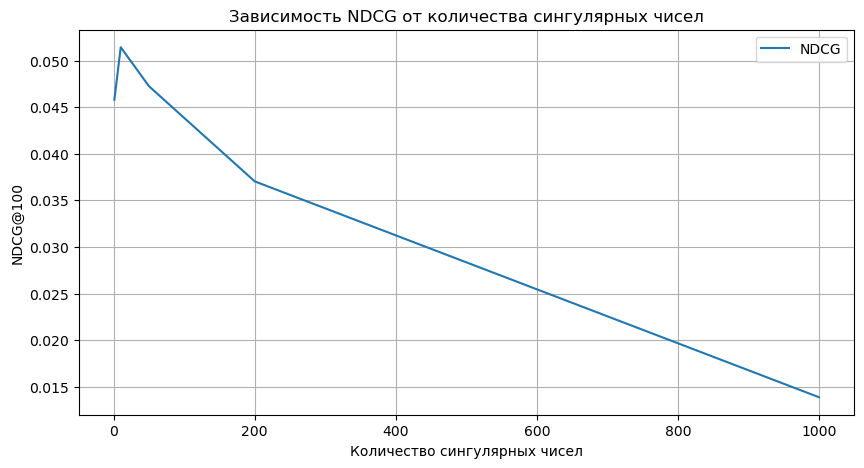

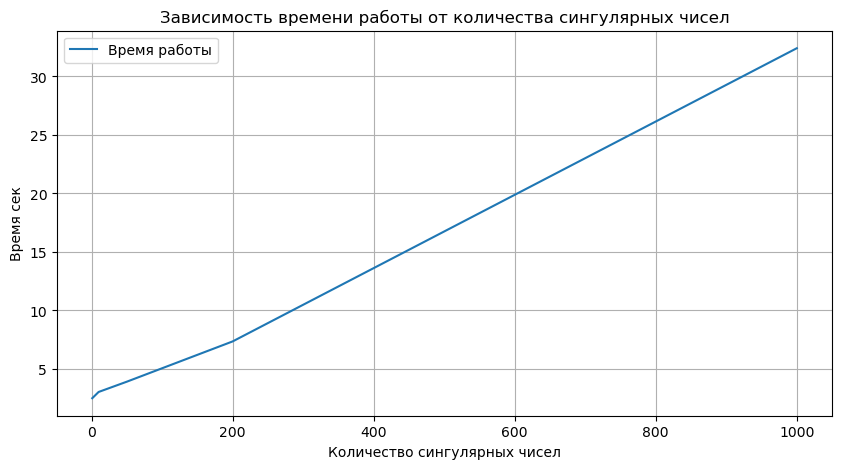

In [29]:
coo_interactions = df_to_coo(df_train)
test_interactions_coo = df_to_coo(df_test)

plot_graphs(coo_interactions, test_interactions_coo)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [31]:
def make_als_recommendations(
        interactions: Union[np.ndarray, coo_array],
        top_k: int = 100,
        n_factors: int = 100,
        alpha: float = 1.0,
        regularization: float = 0.01,
        iterations=15,
        random_state=42
):
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)
    elif isinstance(interactions, coo_array):
        interactions = interactions.tocsr()

    als = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha, iterations=iterations,
                                  random_state=42)
    als.fit(interactions)

    n_users = interactions.shape[0]
    recommendations = np.zeros((n_users, top_k), dtype=np.int32)
    for user in range(n_users):
        user_items = interactions[user]
        recs = als.recommend(userid=user, user_items=user_items, N=top_k, filter_already_liked_items=True)
        recommendations[user] = recs[0]
    return recommendations, als

In [32]:
recs, als = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/opt/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [33]:
print('NDCG для iALS:', compute_ndcg(recs, test_interactions_coo, top_k=100))


NDCG для iALS: 0.043154068770066674


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [35]:
movies_df = pd.read_csv("ml-1m/movies.dat", sep="::", engine="python", names=["movie_id", "title", "genres"],
                        encoding='ISO-8859-1')
valid_ids = set(item_le.classes_)
movies_df = movies_df[movies_df['movie_id'].isin(valid_ids)].copy()
movies_df['encoded_id'] = item_le.transform(movies_df['movie_id'])


In [36]:
def explain_recommendations_for_users(
        als_model: AlternatingLeastSquares,
        interactions: csr_matrix,
        user_ids: list[int],
        id_to_title: dict[int, str],
        top_k: int = 5,
        n_contributors: int = 3
):
    results = {}

    for user_id in user_ids:
        user_items = csr_matrix(interactions[[user_id]])
        recs = als_model.recommend(
            userid=user_id,
            user_items=user_items,
            N=top_k,
            filter_already_liked_items=True
        )
        recommended_items, scores = recs
        explanations = []

        for idx, item_id in enumerate(recommended_items):
            total_score, top_contributions, user_weights = als_model.explain(user_id, interactions, item_id,
                                                                             N=n_contributors)
            top_contributors_named = [
                (id_to_title.get(src_item_id), w)
                for (src_item_id, w) in top_contributions
            ]
            explanations.append({
                'rank': idx + 1,
                'recommended_item_id': item_id,
                'recommended_item_title': id_to_title.get(item_id),
                'overall_score': total_score,
                'top_contributors': top_contributors_named
            })

        results[user_id] = explanations
    return results

In [37]:
id_to_title = dict(zip(movies_df['encoded_id'], movies_df['title']))
interactions_csr = csr_matrix(coo_interactions)
users_to_explain = [23, 3000, 1002]

explanations = explain_recommendations_for_users(
    als,
    interactions_csr,
    users_to_explain,
    id_to_title,
    top_k=5,
    n_contributors=3
)

for user_id, user_expls in explanations.items():
    print(f'Объяснение рекомендаций для пользователя {user_id}:\n')
    for e in user_expls:
        print(f'   Ранк {e['rank']} -> {e['recommended_item_title']!r} (item_id={e['recommended_item_id']})')
        print(f'   ALS score = {e['overall_score']:.4f}')
        print('   Наибольший вклад внесли фильмы:')
        for movie_title, weight in e['top_contributors']:
            print(f"      {movie_title!r}: {weight:.4f}")
        print()
    print("--------------------------------------------------\n")

Объяснение рекомендаций для пользователя 23:

   Ранк 1 -> 'Witness (1985)' (item_id=1243)
   ALS score = 0.7871
   Наибольший вклад внесли фильмы:
      'When Harry Met Sally... (1989)': 0.0925
      'Room with a View, A (1986)': 0.0826
      'Gandhi (1982)': 0.0781

   Ранк 2 -> 'Die Hard (1988)' (item_id=775)
   ALS score = 0.7637
   Наибольший вклад внесли фильмы:
      'Indiana Jones and the Last Crusade (1989)': 0.1605
      'Terminator, The (1984)': 0.1458
      'Raiders of the Lost Ark (1981)': 0.1023

   Ранк 3 -> 'Raising Arizona (1987)' (item_id=1053)
   ALS score = 0.7597
   Наибольший вклад внесли фильмы:
      'Fish Called Wanda, A (1988)': 0.1391
      'This Is Spinal Tap (1984)': 0.1080
      'Airplane! (1980)': 0.0954

   Ранк 4 -> 'Back to the Future (1985)' (item_id=947)
   ALS score = 0.7496
   Наибольший вклад внесли фильмы:
      'Blade Runner (1982)': 0.1218
      'When Harry Met Sally... (1989)': 0.1182
      'Airplane! (1980)': 0.1171

   Ранк 5 -> 'Star Wars: 

Видно, что рекомендации вполне логичные, например, пользователю 1 рекомендуется фильм Star Wars: Episode IV — A New Hope на основе других фильмов Star Wars

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [40]:
def transoform_train(df_train: pd.DataFrame, variant: int, max_date) -> pd.DataFrame:
    df_transformed = df_train.copy()

    if variant == 0:
        return df_transformed
    elif variant == 1:
        df_transformed['rating'] = 1
    elif variant == 2:
        df_transformed['rating'] = df_transformed['rating'].apply(lambda x: 1 if x >= 4 else 0)
    elif variant == 3:
        df_transformed['rating'] = df_transformed['rating'].apply(lambda x: 1 if x >= 4 else -1)
    elif variant == 4:
        def month_diff(d1, d2):
            return (d2.year - d1.year) * 12 + (d2.month - d1.month)

        def transform_row(row):
            base_rating = 1 if row['rating'] >= 4 else -1
            m_diff = month_diff(row['datetime'], max_date)
            return base_rating * (0.75 ** abs(m_diff))

        df_transformed['rating'] = df_transformed.apply(transform_row, axis=1)
    return df_transformed


results = []
max_date_train = df_train['datetime'].max()

for variant in [0, 1, 2, 3, 4]:
    df_train_transformed = transoform_train(df_train, variant, max_date=max_date_train)
    train_df = df_to_matrix(df_train_transformed)
    test_df = df_to_coo(df_test)

    als_recs, _ = make_als_recommendations(interactions=train_df)
    als_ndcg = compute_ndcg(als_recs, test_df, top_k=100)

    svd_recs = make_svd_recommendations(train_df, n_singular_values=10, top_k=100)
    svd_ndcg = compute_ndcg(svd_recs, test_df, top_k=100)

    results.append({
        'variant': variant,
        'ALS_ndcg': als_ndcg,
        'SVD_ndcg': svd_ndcg,
    })

results_df = pd.DataFrame(results)
display(results_df)
# в вариатнте 0 используется исходный датасет

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,variant,ALS_ndcg,SVD_ndcg
0,0,0.043154,0.051434
1,1,0.042628,0.049496
2,2,0.037675,0.045287
3,3,0.043250,0.047361
4,4,0.042961,0.048113


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [42]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef=0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        self._p = None
        self._fited = False

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        p = (interactions > 0).astype(np.float64)
        C = 1 + self.alpha * interactions
        reg_I = np.diag([self.reg_coef] * self.n_factors)

        X = np.random.normal(size=(n_users, self.n_factors))
        Y = np.random.normal(size=(n_items, self.n_factors))

        for iteration in trange(n_iterations):
            YtY = Y.T @ Y
            for u in range(n_users):
                indices = np.where(p[u] > 0)[0]
                A = YtY.copy()
                b = np.zeros(self.n_factors)  # сумма conf * y_i
                for i in indices:
                    y_i = Y[i]
                    conf = C[u, i]  # уверенность для пары юзер айтем
                    A += (conf - 1) * np.outer(y_i, y_i)  # C_u = I + (C_u - I)
                    b += conf * y_i
                A += reg_I
                X[u] = np.linalg.solve(A, b)

            XtX = X.T @ X
            for i in range(n_items):
                indices = np.where(p[:, i] > 0)[0]
                A = XtX.copy()
                b = np.zeros(self.n_factors)
                for u in indices:
                    x_u = X[u]
                    conf = C[u, i]
                    A += (conf - 1) * np.outer(x_u, x_u)
                    b += conf * x_u
                A += reg_I
                Y[i] = np.linalg.solve(A, b)

        self.user_factors = X
        self.item_factors = Y
        self._p = p
        self._fited = True

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        if not self._fited:
            raise ValueError

        scores = self.user_factors @ self.item_factors.T
        n_users, n_items = scores.shape
        predicts = np.zeros((n_users, top_k), dtype=np.int32)
        for u in range(n_users):
            user_scores = scores[u]
            user_scores[self._p[u] > 0] = -np.inf
            top_items = np.argpartition(user_scores, -top_k)[-top_k:]
            predicts[u] = top_items
        return predicts  # shape ~ [n_users, top_k]

In [43]:
model = iALS(n_factors=10)

model.fit(interactions, n_iterations=10)

top_k = 100
recs = model.predict(top_k=top_k)

ndcg_val = compute_ndcg(recs, test_interactions_coo, top_k=top_k)
print('NDCG для кастомной модели iALS:', ndcg_val)

100%|███████████████████████████████████████████| 10/10 [01:31<00:00,  9.20s/it]


NDCG для кастомной модели iALS: 0.051184999967626536
